In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, homogeneity_score, completeness_score, v_measure_score
from sklearn.metrics import silhouette_score, davies_bouldin_score
import seaborn as sb

In [125]:
def split_dataset(data):
    train_val = data.groupby("quality", group_keys=False)[data.columns].sample(frac=0.8)
    test = data.drop(train_val.index)
    train = train_val.groupby("quality", group_keys=False)[train_val.columns].sample(frac=0.75)
    validation = train_val.drop(train.index)    
    return [train, validation, test]

def check_split_dataset(data):
    print(data[0]["quality"].value_counts()/data[0].shape[0])
    print(data[1]["quality"].value_counts()/data[1].shape[0])
    print(data[2]["quality"].value_counts()/data[2].shape[0])

def split_targets_and_features(data):
    targets = data.quality
    features = data.drop("quality", axis=1)

    return [features, targets]

def create_set_of_targets_and_features(data, min_max=False, mean=False):
    train = split_targets_and_features(data[0])
    validation = split_targets_and_features(data[1])
    test = split_targets_and_features(data[2])

    #funksjon for min_max normalisering av data
    if(min_max):
        scaler_min_max = MinMaxScaler()
        scaler_min_max.fit(train[0])
        train[0] = pd.DataFrame(scaler_min_max.transform(train[0]), columns=train[0].columns)
        validation[0] = pd.DataFrame(scaler_min_max.transform(validation[0]), columns=validation[0].columns)
        test[0] = pd.DataFrame(scaler_min_max.transform(test[0]), columns=test[0].columns)    
    
    # funksjon for mean normalisering av data
    if(mean):
        scaler_mean = StandardScaler()
        scaler_mean.fit(train[0])
        train[0] = pd.DataFrame(scaler_mean.transform(train[0]), columns=train[0].columns)
        validation[0] = pd.DataFrame(scaler_mean.transform(validation[0]), columns=validation[0].columns)
        test[0] = pd.DataFrame(scaler_mean.transform(test[0]), columns=test[0].columns)

    return [train, validation, test]

# hovedfunksjon for splitting av dataset med valgmulighet for normalisering
def create_full_dataset(input, min_max=False, mean=False):
    data = split_dataset(input)
    dataset = create_set_of_targets_and_features(data, min_max, mean)

    return dataset

In [126]:
def evaluate_model_external(true_labels, pred_labels):
    adjusted_rand = adjusted_rand_score(true_labels, pred_labels)
    homogeneity = homogeneity_score(true_labels, pred_labels)
    completeness = completeness_score(true_labels, pred_labels) 
    v_measure = v_measure_score(true_labels, pred_labels)

    return [adjusted_rand, homogeneity, completeness, v_measure]

def external_results_print(adjusted_rand, homogeneity, completeness, v_measure):
    print(f'Adjusted rand score: {np.mean(adjusted_rand):.2f} +- {np.std(adjusted_rand):.2f}')
    print(f'Homogeneity score: {np.mean(homogeneity):.2f} +- {np.std(homogeneity):.2f}')
    print(f'Completness score: {np.mean(completeness):.2f} +- {np.std(completeness):.2f}')
    print(f'V-measure score: {np.mean(v_measure):.2f} +- {np.std(v_measure):.2f}')

def evaluate_model_internal(data_features, pred_labels):
    silhouette = silhouette_score(data_features, pred_labels)
    davies = davies_bouldin_score(data_features, pred_labels)
    
    return [silhouette, davies]

def internal_results_print(silhouette, davies):
    print(f'Silhouette score: {np.mean(silhouette):.2f} +- {np.std(silhouette):.2f}')
    print(f'Davies score: {np.mean(davies):.2f} +- {np.std(davies):.2f}')

def append_values(results_external, results_internal, adjusted_rand, homogeneity, completeness, v_measure, silhouette, davies):
        adjusted_rand.append(results_external[0])
        homogeneity.append(results_external[1])
        completeness.append(results_external[2])
        v_measure.append(results_external[3])
        silhouette.append(results_internal[0])
        davies.append(results_internal[1])

def validate_kmeans(classifier, runs, test=False, min_max=False, mean=False):
    train_adjusted_rand, train_homogeneity, train_completeness, train_v_measure, train_silhouette, train_davies = [], [], [], [], [], []
    validate_adjusted_rand, validate_homogeneity, validate_completeness, validate_v_measure, validate_silhouette, validate_davies = [], [], [], [], [], []
    test_adjusted_rand, test_homogeneity, test_completeness, test_v_measure, test_silhouette, test_davies = [], [], [], [], [], []

    if(runs < 1): runs = 1

    for i in range(0, runs, 1):
        dataset = create_full_dataset(df, min_max, mean)
        model = classifier.fit(dataset[0][0])
        pred_train = model.labels_
        pred_validate = model.predict(dataset[1][0])
        pred_test = model.predict(dataset[2][0])

        r_train_external = evaluate_model_external(dataset[0][1], pred_train)
        r_train_internal = evaluate_model_internal(dataset[0][0], pred_train)
        append_values(r_train_external, r_train_internal, train_adjusted_rand, train_homogeneity, train_completeness, 
                      train_v_measure, train_silhouette, train_davies)
        
        r_validate_external = evaluate_model_external(dataset[1][1], pred_validate)
        r_validate_internal = evaluate_model_internal(dataset[1][0], pred_validate)
        append_values(r_validate_external, r_validate_internal, validate_adjusted_rand, validate_homogeneity, validate_completeness, 
                      validate_v_measure, validate_silhouette, validate_davies)
        
        if(test):
            r_test_external = evaluate_model_external(dataset[2][1], pred_test)
            r_test_internal = evaluate_model_internal(dataset[2][0], pred_test)
            append_values(r_test_external, r_test_internal, test_adjusted_rand, test_homogeneity, test_completeness, 
                      test_v_measure, test_silhouette, test_davies)

    print('Traning ressults:')
    print('**********************************')
    print('External:')
    external_results_print(train_adjusted_rand, train_homogeneity, train_completeness, train_v_measure)
    print('**********************************')
    print("Internal:")
    internal_results_print(train_silhouette, train_davies)
    print('')
    print('Validation results:')
    print('**********************************')
    print('External:')
    external_results_print(validate_adjusted_rand, validate_homogeneity, validate_completeness, validate_v_measure)
    print('**********************************')
    print('Internal:')
    internal_results_print(validate_silhouette, validate_davies)
    if(test):
        print('')
        print('Test results:')
        print('**********************************')
        print('External:')
        external_results_print(test_adjusted_rand, test_homogeneity, test_completeness, test_v_measure)
        print('**********************************')
        print('Internal:')
        internal_results_print(test_silhouette, test_davies)

def validate_agglomerative(classifier, min_max=False, mean=False):
    adjusted_rand, homogeneity, completeness, v_measure, silhouette, davies = [], [], [], [], [], []
    dataset = split_targets_and_features(df)

    if(min_max):
        scaler_min_max = MinMaxScaler()
        scaler_min_max.fit(dataset[0])
        dataset[0] = pd.DataFrame(scaler_min_max.transform(dataset[0]), columns=dataset[0].columns)

    if(mean):
        scaler_mean = StandardScaler()
        scaler_mean.fit(dataset[0])
        dataset[0] = pd.DataFrame(scaler_mean.transform(dataset[0]), columns=dataset[0].columns)

    model = classifier.fit(dataset[0])
    pred_labels = model.labels_    

    r_external = evaluate_model_external(dataset[1], pred_labels)
    r_internal = evaluate_model_internal(dataset[0], pred_labels)
    append_values(r_external, r_internal, adjusted_rand, homogeneity, completeness, 
                      v_measure, silhouette, davies)

    print('Ressults:')
    print('**********************************')
    print('External:')
    external_results_print(adjusted_rand, homogeneity, completeness, v_measure)
    print('**********************************')
    print("Internal:")
    internal_results_print(silhouette, davies)

def optimise_k_means(data, max_cluster):
    means = []
    inertias = []
    for c in range(1, max_cluster):
        kmeans = KMeans(n_clusters=c)
        kmeans.fit(data)

        means.append(c)
        inertias.append(kmeans.inertia_)
    fig = plt.subplots(figsize=(10,5))
    plt.plot(means, inertias, "o-")
    plt.xlabel('Number og Cluser')
    plt.ylabel('Inertia')
    plt.grid(True)
    plt.show()




In [128]:
df = pd.read_csv("../Oblig2/winequality-red.csv", delimiter=";")
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [129]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


Hensikten med datasettet er å muliggjøre analyse og modellering av vin kvalitet ut ifra forskjellige målte karaterestikker (features) som for eks. «fixed acidity», «citric acid» osv.
Datasettet innehold en target verdi kolonne, «quality». Kolonnen oppgir en vurdering av kvaliteten til vinen og skal være oppgitt i en int-verdi fra 1-10 [1].
Videre inneholder datasettet 11 kolonner med feature verdier som beskrive forskjellige målte kjemiske egenskaper vinen har. Alle disse kolonnen har et float verdiformat.

ref [1]: UCI Irvine. (u.å). Wine Quality. Hentet 12.10.2025 fra "https://archive.ics.uci.edu/dataset/186/wine+quality"

In [22]:
df.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

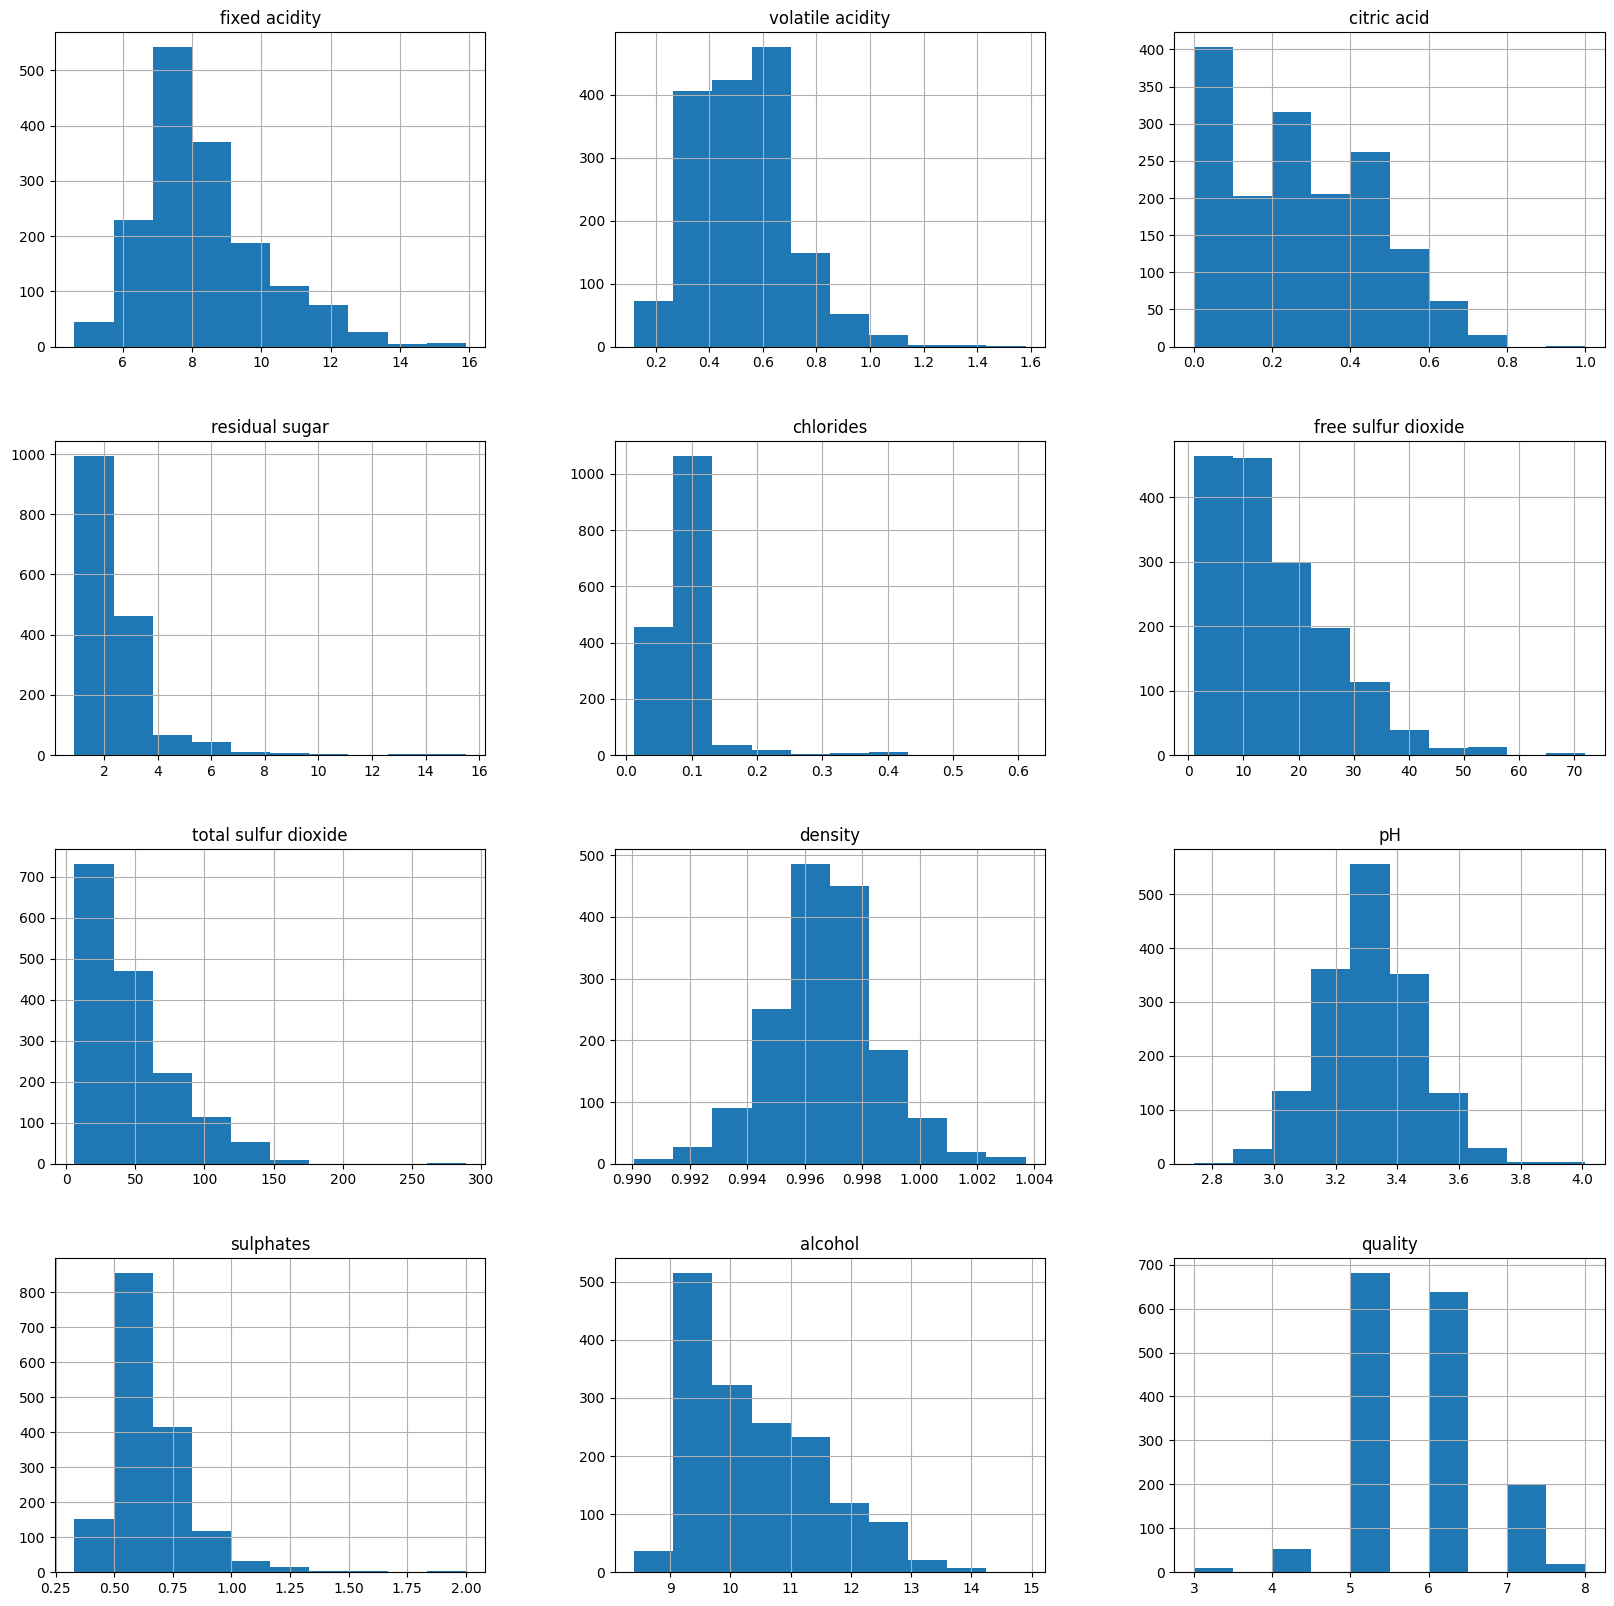

In [130]:
df.hist(figsize=(20,20))
plt.show()

<Axes: xlabel='quality'>

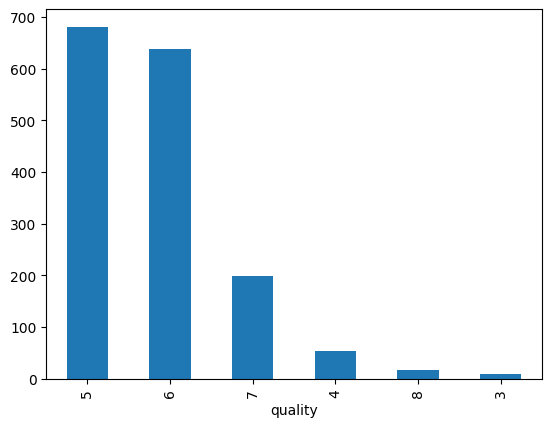

In [23]:
df['quality'].value_counts().plot.bar()

In [ ]:
features.hist(figsize=(20,20))
plt.show()

In [132]:
kmeans = KMeans(n_clusters=7)
validate_kmeans(kmeans, 5, True, True, False)

Traning ressults:
**********************************
External:
Adjusted rand score: 0.05 +- 0.01
Homogeneity score: 0.13 +- 0.01
Completness score: 0.08 +- 0.01
V-measure score: 0.10 +- 0.01
**********************************
Internal:
Silhouette score: 0.18 +- 0.02
Davies score: 1.65 +- 0.06

Validation results:
**********************************
External:
Adjusted rand score: 0.05 +- 0.01
Homogeneity score: 0.14 +- 0.01
Completness score: 0.09 +- 0.01
V-measure score: 0.11 +- 0.01
**********************************
Internal:
Silhouette score: 0.16 +- 0.01
Davies score: 1.62 +- 0.09

Test results:
**********************************
External:
Adjusted rand score: 0.06 +- 0.01
Homogeneity score: 0.15 +- 0.03
Completness score: 0.10 +- 0.02
V-measure score: 0.12 +- 0.02
**********************************
Internal:
Silhouette score: 0.17 +- 0.02
Davies score: 1.66 +- 0.08


In [127]:
agg = AgglomerativeClustering(n_clusters=5)
validate_agglomerative(agg, False, True)

Ressults:
**********************************
External:
Adjusted rand score: 0.06 +- 0.00
Homogeneity score: 0.09 +- 0.00
Completness score: 0.08 +- 0.00
V-measure score: 0.08 +- 0.00
**********************************
Internal:
Silhouette score: 0.15 +- 0.00
Davies score: 1.56 +- 0.00


husk å sjekk om det er hensiktsmessig å upsample????

all data ser ut til å være normalfordel eller en sidig normalfordelt

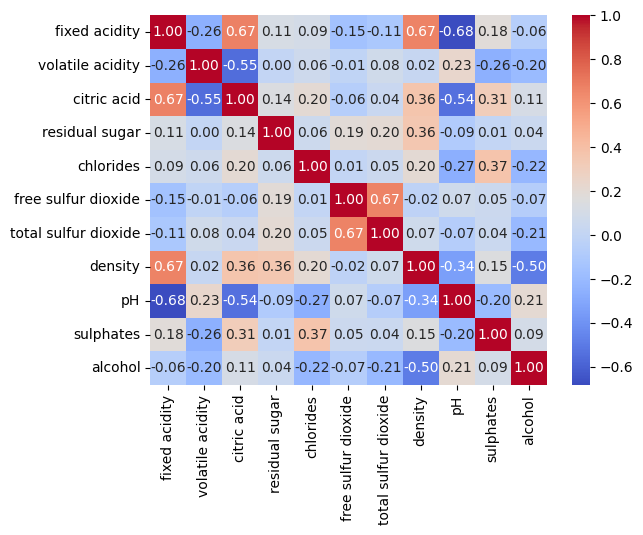

In [10]:
matrix = df_features.corr()


sb.heatmap(matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.show()

ingen punkter som har en en corr over 0.7 eller -0.7 velger derfor å ikke gjøre noe i utgangspunktet.

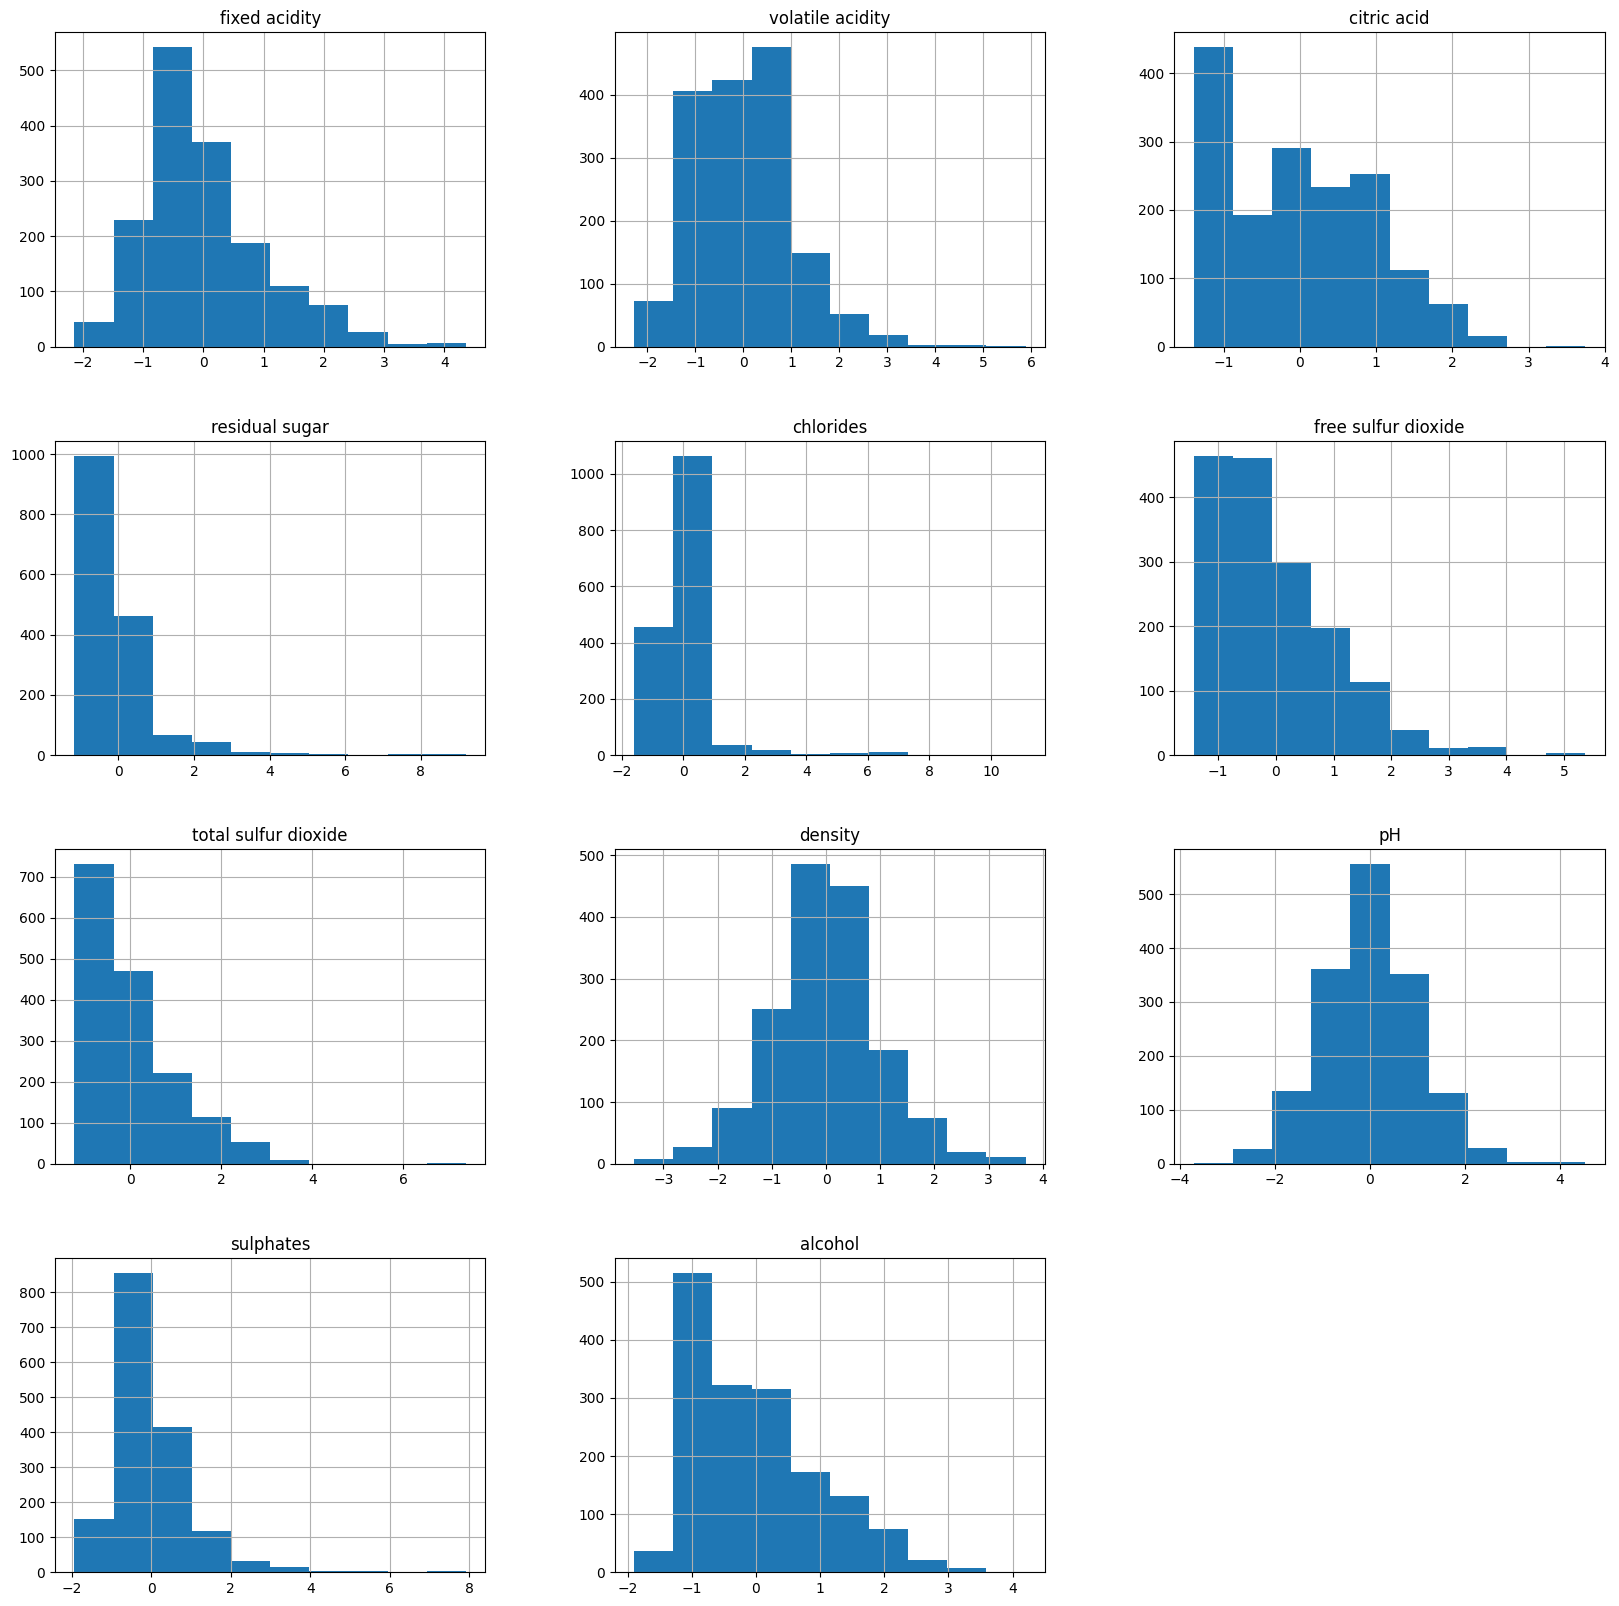

In [ ]:

df_features.hist(figsize=(20,20))
plt.show()

Hensiktsmessig med normalisering pga. stor forskjellig x verdier
valg å bruke.....
som vi ser av resutlat så er----

husk å kjør enkel sammenlignings test......

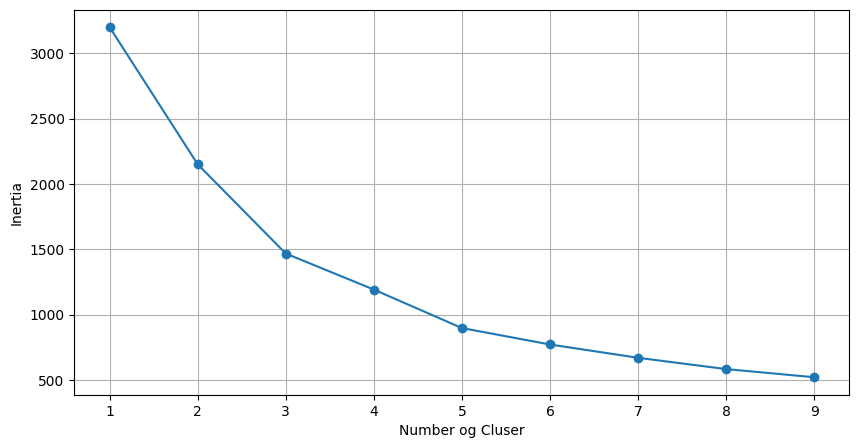

In [13]:


optimise_k_means(df_features[["pH", "sulphates"]], 10)